In [1]:
import arviz as az
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import GPy
import pymc3 as pm
from warnings import filterwarnings
filterwarnings('ignore')
import seaborn as sns
# sns.set() # Setting seaborn as default style even if use only matplotlib
import os
os.environ['PYTHONHASHSEED'] = '0'
plt.rcParams.update({'font.size': 10})

In [2]:
seed = seed_subset_selection = 9 # Randomness 
np.random.seed(seed)

In [3]:
resultdir = os.path.join(os.getcwd(), 'SGPR_results' ,str(seed)+'-seed') 

if not os.path.exists(resultdir):
    os.makedirs(resultdir)

In [4]:
import os
path = (os.path.join(os.getcwd(), '..'))

### NSF DMREF - Experimental

Consider the following dataset:

In [5]:
raw_data = pd.read_csv(os.path.join(path,'Strength_Hardness_with_Descriptors-Sh.csv'), index_col=0)
display(raw_data)

,level_0,index,IDENTIFIER: Reference ID,FORMULA,PROPERTY: Microstructure,PROPERTY: Processing method,PROPERTY: grain size ($\mu$m),PROPERTY: ROM Density (g/cm$^3$),PROPERTY: Exp. Density (g/cm$^3$),PROPERTY: HV,...,pugh,VEC,SMIX,ModulusMX,DensityMX,TmMX,R_MX,shearMX,bulkMX,VECMX
0,0,0,27,Al0.25 Co1 Fe1 Ni1,FCC,CAST,NaN,7.9,NaN,138.0,...,2.292276,8.538462,1.285293,141.0,6.209282,877.68,19.05,56.0,104.0,7.0
1,1,1,27,Al0.5 Co1 Fe1 Ni1,FCC+BCC,CAST,NaN,7.4,NaN,212.0,...,2.308943,8.142857,1.351784,141.0,6.209282,877.68,19.05,56.0,104.0,7.0
2,2,2,27,Al0.75 Co1 Fe1 Ni1,FCC+BCC,CAST,NaN,7.0,NaN,385.0,...,2.324752,7.800000,1.379292,141.0,6.209282,877.68,19.05,56.0,104.0,7.0
3,3,3,27,Al1 Co1 Fe1 Ni1,BCC,CAST,NaN,6.6,NaN,456.0,...,2.339768,7.500000,1.386294,141.0,6.209282,877.68,19.05,56.0,104.0,7.0
4,4,4,27,Co1 Fe1 Ni1,FCC,CAST,NaN,8.5,NaN,125.0,...,2.274678,9.000000,1.098612,11.0,1.030567,83.00,0.98,7.0,10.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,388,1562,116,Al0.6 Co1 Cr0.333 Fe0.333 Mo0.1 Ni0.967,No Data,CAST,NaN,NaN,NaN,359.7,...,2.298516,7.720372,1.594375,259.0,7.529991,1962.68,19.05,95.0,154.0,7.0
154,393,1574,121,Nb1 Ta1 Ti1 Zr1,BCC,CAST,500.0,NaN,NaN,358.0,...,3.092391,4.500000,1.386294,118.0,12.175346,1349.00,17.35,36.0,111.0,1.0
155,394,1578,121,Nb1 Ta0.667 Ti0.667 Zr0.333,No Data,CAST,500.0,NaN,NaN,294.0,...,3.267988,4.625047,1.320810,118.0,12.175346,1349.00,17.35,36.0,111.0,1.0
156,397,1631,131,Al0.267 Co1 Cr0.667 Fe0.667 Ni0.667 Ti0.2,No Data,POWDER,NaN,NaN,NaN,515.0,...,2.061561,7.672722,1.671721,209.0,6.209282,1246.68,22.03,89.0,104.0,7.0


Extracting all relevant features:

In [6]:
# The unscaled input and output features
RoM = ['Density', 'Modulus', 'Tm', 'Misfit', 'Rbar', 'delta', 'shear', 'bulk', 'VEC', 'SMIX']
MX = ['ModulusMX', 'DensityMX', 'TmMX', 'R_MX', 'shearMX', 'bulkMX', 'VECMX']
Phase = ['Phase_BCC', 'Phase_BCC+BCC', 'Phase_BCC+Sec.', 'Phase_FCC', 'Phase_FCC+BCC', 'Phase_FCC+Sec.', 'Phase_No Data', 'Phase_Other']
X = RoM + MX + Phase
# Curtin = 'Delta_SS'
H = 'PROPERTY: HV'
S = 'PROPERTY: YS (MPa)'

## SGPR

In this Case, we are going to build a Strength model using GP

using {X=[X_f(above),z_f], Y=y_f}, mean prediction = f_pred 

In [7]:
print ('Splitting')
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(raw_data, test_size=0.2, random_state=seed_subset_selection)
print (data_train.shape, data_test.shape)
# print (data_train[:2])
# print (data_test[:2])

Splitting
(126, 94) (32, 94)


In [8]:
print ('Pre-processing the data for GP_f building')
print ('Step1: Seperating')
X_f, z_f, y_f = data_train[X].values, data_train[H].values[:, None], data_train[S].values[:, None] 
X_test, z_test, y_test = data_test[X].values, data_test[H].values[:, None], data_test[S].values[:, None] 

print('Step2: Scaling [X_f, z_f], Scaling y_f')
# scale train data and use those means and dev for scaling test data to avoid info leakage
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_X.fit(X_f)
X_f_s, X_test_s = scaler_X.transform(X_f), scaler_X.transform(X_test)
scaler_z = StandardScaler()
scaler_z.fit(z_f)
z_f_s, z_test_s = scaler_z.transform(z_f), scaler_z.transform(z_test)
scaler_y = StandardScaler()
scaler_y.fit(y_f)
y_f_s, y_test_s = scaler_y.transform(y_f), scaler_y.transform(y_test)

Pre-processing the data for GP_f building
Step1: Seperating
Step2: Scaling [X_f, z_f], Scaling y_f


In [9]:
print ('Training and testing dataset sizes')
print (np.shape(X_f_s), np.shape(z_f_s), np.shape(y_f_s))
print (np.shape(X_test_s), np.shape(z_test_s), np.shape(y_test_s))

Training and testing dataset sizes
(126, 25) (126, 1) (126, 1)
(32, 25) (32, 1) (32, 1)


In [10]:
print ('Building GP_f between [X_f_s,z_f_s] and y_f_s')
kf = GPy.kern.RBF(np.hstack((X_f_s,z_f_s)).shape[1], ARD=True)
mf = GPy.models.GPRegression(np.hstack((X_f_s,z_f_s)), y_f_s, kf)
mf.optimize_restarts()
print(mf)
print(mf[".*Gaussian_noise"])
print(mf[".*rbf"])

Building GP_f between [X_f_s,z_f_s] and y_f_s
Optimization restart 1/10, f = 46.65060429719325
Optimization restart 2/10, f = 67.43728587470841
Optimization restart 3/10, f = 63.23565828061106
Optimization restart 4/10, f = 54.75035721089837
Optimization restart 5/10, f = 57.619265851667755
Optimization restart 6/10, f = 52.08467395509016
Optimization restart 7/10, f = 53.321508050397995
Optimization restart 8/10, f = 83.8466748070968
Optimization restart 9/10, f = 56.25137822063527
Optimization restart 10/10, f = 60.53214914329962

Name : GP regression
Objective : 46.65060429719325
Number of Parameters : 28
Number of Optimization Parameters : 28
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |    1.052228512396038  |      +ve      |        
  rbf.lengthscale          |                (26,)  |      +ve      |        
  Gaussian_noise.variance  |  0.00544483238105818  |      +ve      |        
  index  |

In [11]:
print('GP Predictions') # posterior (f|y) and (f*|y)
postsam_f = mf.posterior_samples_f(np.hstack((X_f_s,z_f_s)), size=1000) # posterior_samples_f gives epistemic uncertainity only
postsam_f_un = scaler_y.inverse_transform(postsam_f) # un-normalized values
print (postsam_f_un.shape)

postsam_f_test = mf.posterior_samples_f(np.hstack((X_test_s,z_test_s)), size=1000) # posterior_samples_f gives epistemic uncertainity only
postsam_f_test_un = scaler_y.inverse_transform(postsam_f_test) # un-normalized values 
print (postsam_f_test_un.shape)

mupred_f, varpred_f = np.mean(postsam_f_un, axis=2), np.var(postsam_f_un, axis=2)
mupred_f_test, varpred_f_test = np.mean(postsam_f_test_un, axis=2), np.var(postsam_f_test_un, axis=2)

errbarpred_f = 1.96*np.sqrt(varpred_f)
errbarpred_f_test = 1.96*np.sqrt(varpred_f_test)

GP Predictions
(126, 1, 1000)
(32, 1, 1000)


GP Predictions plots
************************************************
Strength MRel.AE train: 0.016003745130134372
Strength MRel.AE test: 0.45591044525322166
Strength MAE train: 15.617234049954895
Strength MAE test: 383.0225007973364
************************************************


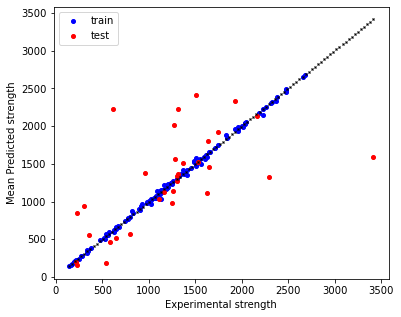

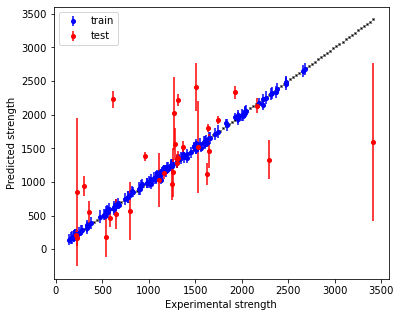

In [12]:
from sklearn.metrics import mean_absolute_error
def mean_relative_absolute_error(y_true, y_pred): 
    return np.mean( np.abs((y_pred-y_true)/y_true) )

print('GP Predictions plots')
Strength_MRelAE_train = mean_relative_absolute_error( y_f, mupred_f )
Strength_MRelAE_test = mean_relative_absolute_error( y_test, mupred_f_test)

Strength_MAE_train = mean_absolute_error( y_f,  mupred_f )
Strength_MAE_test = mean_absolute_error( y_test,  mupred_f_test)

print ('************************************************')
print ('Strength MRel.AE train: '+str(Strength_MRelAE_train))
print ('Strength MRel.AE test: '+str(Strength_MRelAE_test))

print ('Strength MAE train: '+str(Strength_MAE_train))
print ('Strength MAE test: '+str(Strength_MAE_test))
print ('************************************************')

fit = np.linspace(min(raw_data[S]),max(raw_data[S]),100)

plt.figure(figsize=(6, 5))
plt.subplot(1, 1, 1)
plt.plot(y_f, mupred_f , 'o', color='blue', label='train', markersize=4)
plt.plot(y_test, mupred_f_test, 'o', color='red', label='test', markersize=4)
plt.plot(fit, fit, 'x', label='', color='black',markersize=2)
plt.xlabel('Experimental strength', fontsize=10)
plt.ylabel('Mean Predicted strength', fontsize=10)
plt.legend(fontsize=10)

plt.figure(figsize=(6, 5))
plt.subplot(1, 1,1)
plt.errorbar(y_f, mupred_f, yerr=errbarpred_f.flatten(), fmt='o', color='blue',markersize=4, label='train')
plt.errorbar(y_test, mupred_f_test, yerr=errbarpred_f_test.flatten(), fmt='o', color='red',markersize=4, label='test')
plt.plot(fit, fit, 'x', label='', color='black', markersize=2)
plt.xlabel('Experimental strength', fontsize=10)
plt.ylabel('Predicted strength', fontsize=10)
plt.legend(fontsize=10)

plt.savefig(os.path.join(resultdir,str(seed)+'-'+'Strength.pdf'),dpi=300)
plt.show()
plt.close()

## Diagnostic checks

If the model is correct i.e., if the statistics predicted by model is correct, then ECDF evaluated at the test data should follow a uniform distribution.

In [13]:
postsamples_f = postsam_f[:,0,:].T
postsamples_f_test = postsam_f_test[:,0,:].T
print(postsamples_f.shape, postsamples_f_test.shape)

(1000, 126) (1000, 32)


In [14]:
sigma_f = np.sqrt(mf.Gaussian_noise.variance.values[0])
print(sigma_f)

0.07378910746890885


(1000, 32)
(32, 1)


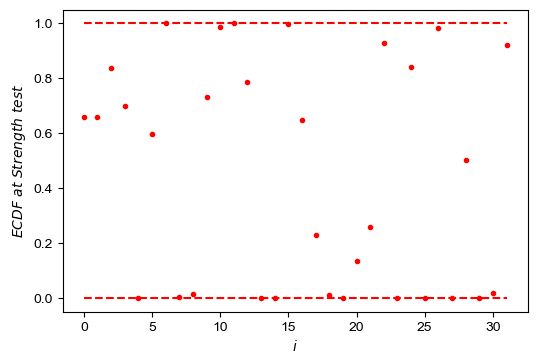

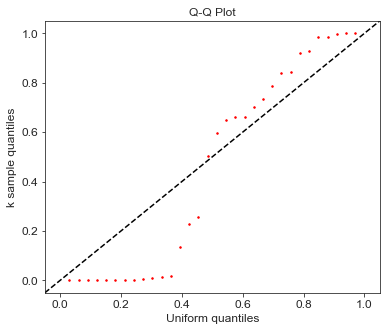

KstestResult(statistic=0.357, pvalue=0.00037164963731538297)


Text(0.5, 0, '$k_i$')

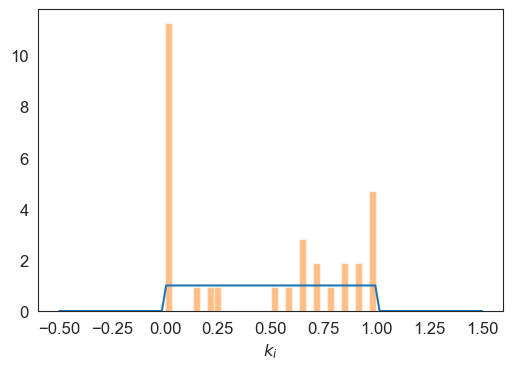

In [15]:
# predictive posterior (y*|y)
predpostsamples_f_test = np.zeros((postsamples_f_test.shape[0], postsamples_f_test.shape[1])) 
for i in range(predpostsamples_f_test.shape[0]):
    predpostsamples_f_test[i,:] = pm.Normal.dist(mu=postsamples_f_test[i,:], 
                                                sigma=sigma_f).random()
predpostsamples_f_test_un = scaler_y.inverse_transform(predpostsamples_f_test)
print (predpostsamples_f_test_un.shape)
print (y_test.shape)

# https://www.statsmodels.org/stable/generated/statsmodels.distributions.empirical_distribution.ECDF.html
from statsmodels.distributions.empirical_distribution import ECDF

ecdf_y_test = []
for i in range(y_test.shape[0]):
    ecdf = ECDF(predpostsamples_f_test_un[:,i]) # Build ECDF with all samples
    ecdf_y_test.append(ecdf(y_test[i])[0]) # CDF evaluated at test points
    
    
fig, ax = plt.subplots(dpi=100)
ax.plot(ecdf_y_test, 'o', color='red', markersize=3)
ax.plot(np.arange(y_test.shape[0]), 0.0 * np.ones(y_test.shape[0]), 'r--')
ax.plot(np.arange(y_test.shape[0]), 1.0 * np.ones(y_test.shape[0]), 'r--')
ax.set_xlabel('$i$')
ax.set_ylabel('$ECDF \ at \ Strength \ test$');

plt.rcParams.update({'font.size': 12})
import statsmodels.api as sm
import scipy.stats as st
import pylab
sns.set_style("white")
fig, ax = plt.subplots(figsize=(6,5))
fig_ = sm.qqplot(np.asarray(ecdf_y_test), st.uniform, loc=0, scale=1, marker='.', markerfacecolor='r', markeredgecolor='r', markersize=3, alpha=1, ax=ax)
sm.qqline(fig_.axes[0], line='45', fmt='k--')
ax.set_title('Q-Q Plot', fontsize=12)
ax.set_xlabel('Uniform quantiles', fontsize=12)
ax.set_ylabel('k sample quantiles', fontsize=12)
ax.tick_params(bottom=True, left=True)
fig.savefig(os.path.join(resultdir,str(seed)+'-'+'q-q_plot_Strength_test.pdf'),dpi=300)
plt.show()
plt.close()

# https://www.geeksforgeeks.org/ml-kolmogorov-smirnov-test/
res = st.kstest(ecdf_y_test,"uniform")    
print(res) 

ks = ecdf_y_test
fig, ax = plt.subplots(dpi=100)
ps = np.linspace(-0.5, 1.5, 100)
ax.plot(ps, st.uniform.pdf(ps))
ax.hist(ks, density=True, alpha=0.5, bins = 30)
ax.set_xlabel('$k_i$')

In [16]:
print ('Required outputs:')
print ('Seed used to split train and test data: '+str(seed_subset_selection)) 
print ('Strength MRel.AE test: '+str(Strength_MRelAE_test))
print ('Strength MAE test: '+str(Strength_MAE_test))
print ('Strength KS test: '+str(res.statistic))

Required outputs:
Seed used to split train and test data: 9
Strength MRel.AE test: 0.45591044525322166
Strength MAE test: 383.0225007973364
Strength KS test: 0.357


In [17]:
y_test

array([[1302.  ],
       [1112.  ],
       [ 793.  ],
       [1160.  ],
       [1923.15],
       [ 220.  ],
       [2297.94],
       [1272.  ],
       [1280.  ],
       [1260.  ],
       [ 540.  ],
       [1625.  ],
       [ 225.  ],
       [1314.5 ],
       [ 618.8 ],
       [3416.  ],
       [2161.7 ],
       [1304.  ],
       [1370.  ],
       [1513.  ],
       [ 230.  ],
       [1317.  ],
       [ 586.  ],
       [ 964.  ],
       [ 650.  ],
       [1641.  ],
       [1250.  ],
       [1749.  ],
       [1525.  ],
       [ 300.  ],
       [ 357.  ],
       [1650.  ]])